In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import class_weight
import xgboost as xgb
import warnings
import optuna
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# Load the preprocessed data
total_df = pd.read_csv('total_df.csv')
agg_total = pd.read_csv('agg_total.csv')

# Convert 'game_date' to datetime format for proper sorting and manipulation
total_df['game_date'] = pd.to_datetime(total_df['game_date'])

# Split the "player_name" column
agg_total[['Last Name', 'First Name']] = agg_total['player_name'].str.split(',', expand=True)

# Remove leading/trailing spaces
agg_total['First Name'] = agg_total['First Name'].str.strip()
agg_total['Last Name'] = agg_total['Last Name'].str.strip()

# Create Full Name in "FirstName LastName" format
agg_total['Full Name'] = agg_total['First Name'] + ' ' + agg_total['Last Name']

# Define a function to determine the role based on pitching in the first inning
def assign_role(group):
    if (group['inning'] == 1).any():
        return 'starter'
    else:
        return 'reliever'

# Apply the function to assign roles
pitcher_game_roles = total_df.groupby(['pitcher', 'game_date']).apply(assign_role).reset_index(name='role')

# Merge the roles back into the main DataFrame
total_df = total_df.merge(pitcher_game_roles, on=['pitcher', 'game_date'], how='left')

In [3]:
# Drop columns with leakage from the imported dataframe
columns_with_leakage = [
    'rolling_xRV_5',
    'rolling_xRV_15',
    'rolling_pitching_plus_5',
    'rolling_pitching_plus_15',
    'rolling_xRV_diff_5',
    'rolling_xRV_diff_15',
    'rolling_pitching_plus_diff_5',
    'rolling_pitching_plus_diff_15',
    'decline_5', 
    'decline_15', 
    'decline_pp_5', 
    'decline_pp_15', 
    'decline',
    'pulled_due_to_decline',
    'xrv_100',
    'xrv_100_adj',
]

# Drop the leaking columns
total_df = total_df.drop(columns=columns_with_leakage)

print("Columns dropped to prevent leakage:", columns_with_leakage)
print("\nRemaining columns:", total_df.columns.tolist())

Columns dropped to prevent leakage: ['rolling_xRV_5', 'rolling_xRV_15', 'rolling_pitching_plus_5', 'rolling_pitching_plus_15', 'rolling_xRV_diff_5', 'rolling_xRV_diff_15', 'rolling_pitching_plus_diff_5', 'rolling_pitching_plus_diff_15', 'decline_5', 'decline_15', 'decline_pp_5', 'decline_pp_15', 'decline', 'pulled_due_to_decline', 'xrv_100', 'xrv_100_adj']

Remaining columns: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', '

In [ ]:
# 1. Initial sorting and cleaning
total_df = total_df.sort_values(['pitcher', 'game_date', 'game_pk', 'at_bat_number', 'pitch_number']).reset_index(drop=True)
total_df['cumulative_pitch_number'] = total_df.groupby(['pitcher', 'game_date']).cumcount() + 1

# 2. Calculate rolling stats for xRV and pitching_plus within the current game (using previous pitches only)
for window in [5, 15]:
    # Rolling xRV averages within the game
    total_df[f'rolling_xRV_{window}'] = total_df.groupby(['pitcher', 'game_date'])['xRV'].apply(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    ).reset_index(level=[0,1], drop=True)
    
    # Rolling pitching_plus averages within the game
    total_df[f'rolling_pitching_plus_{window}'] = total_df.groupby(['pitcher', 'game_date'])['pitching_plus'].apply(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    ).reset_index(level=[0,1], drop=True)
    
    # Calculate differences against rolling averages within the game
    total_df[f'rolling_xRV_diff_{window}'] = total_df['xRV'] - total_df[f'rolling_xRV_{window}']
    total_df[f'rolling_pitching_plus_diff_{window}'] = total_df['pitching_plus'] - total_df[f'rolling_pitching_plus_{window}']


# 3. Calculate in-game stats using expanding window (with shift to avoid leakage)
# Avoid using groupby().apply() to reduce memory usage
total_df['shifted_xRV'] = total_df.groupby(['pitcher', 'game_date'])['xRV'].shift(1)
total_df['mean_xRV'] = total_df.groupby(['pitcher', 'game_date'])['shifted_xRV'].expanding().mean().reset_index(level=[0,1], drop=True)
total_df['std_xRV'] = total_df.groupby(['pitcher', 'game_date'])['shifted_xRV'].expanding().std().fillna(0).reset_index(level=[0,1], drop=True)
total_df['xRV_game_dev'] = total_df['xRV'] - total_df['mean_xRV']

total_df['shifted_pitching_plus'] = total_df.groupby(['pitcher', 'game_date'])['pitching_plus'].shift(1)
total_df['mean_pitching_plus'] = total_df.groupby(['pitcher', 'game_date'])['shifted_pitching_plus'].expanding().mean().reset_index(level=[0,1], drop=True)
total_df['std_pitching_plus'] = total_df.groupby(['pitcher', 'game_date'])['shifted_pitching_plus'].expanding().std().fillna(0).reset_index(level=[0,1], drop=True)


# 4. Calculate rolling pitches from previous games
# Calculate total pitches per game per pitcher
pitches_per_game = total_df.groupby(['pitcher', 'game_date'])['pitch_number'].count().reset_index()
pitches_per_game = pitches_per_game.sort_values(['pitcher', 'game_date'])

# Calculate rolling average of pitches over the last 3 games
pitches_per_game['rolling_pitches_3'] = pitches_per_game.groupby('pitcher')['pitch_number'].apply(
    lambda x: x.shift(1).rolling(window=3, min_periods=3).mean()
).reset_index(level=0, drop=True)

# Merge back to total_df
total_df = total_df.merge(
    pitches_per_game[['pitcher', 'game_date', 'rolling_pitches_3']],
    on=['pitcher', 'game_date'],
    how='left'
)

# 5. Calculate historical xRV deviation
total_df['historical_avg_xRV'] = total_df.groupby('pitcher')['xRV'].apply(
    lambda x: x.shift(1).expanding().mean()
).reset_index(level=0, drop=True)
total_df['xRV_dev'] = total_df['xRV'] - total_df['historical_avg_xRV']

# 6. Set target variable if not already present
if 'is_last_pitch' not in total_df.columns:
    total_df['is_last_pitch'] = total_df.groupby(['pitcher', 'game_date'])['cumulative_pitch_number'].transform('max') == total_df['cumulative_pitch_number']

# Inning XRV - using expanding mean within inning
total_df['inning_cumulative_xRV'] = total_df.groupby(['pitcher', 'game_date', 'inning'])['xRV'].expanding().sum().reset_index(level=[0,1,2], drop=True)

# Game XRV - using expanding sum across game
total_df['game_cumulative_xRV'] = total_df.groupby(['pitcher', 'game_date'])['xRV'].expanding().sum().reset_index(level=[0,1], drop=True)

# XRV per pitch - using only data up to current pitch
total_df['xRV_per_pitch'] = total_df['game_cumulative_xRV'] / total_df['cumulative_pitch_number']

# Inning average using only completed innings
total_df['previous_innings_avg_xRV'] = total_df.groupby(['pitcher', 'game_date', 'inning'])['xRV'].transform('sum').shift(1)

print(f"Final shape after feature engineering: {total_df.shape}")
print("\nMissing values in engineered features:")

Final shape after feature engineering: (703480, 179)

Missing values in engineered features:


In [5]:
def compute_balls_strikes_ratio(df):
    """
    Computes the running count of balls and strikes for each pitcher in each game.
    
    Parameters:
        df (DataFrame): The main DataFrame containing per-pitch data
        
    Returns:
        DataFrame: The DataFrame with running ball/strike counts and ratio
    """
    # Create indicators for balls and strikes based on description
    df['is_ball'] = df['description'].isin(['ball', 'blocked_ball', 'pitchout'])
    df['is_strike'] = df['description'].isin(['called_strike', 'swinging_strike', 
                                            'swinging_strike_blocked', 'foul', 
                                            'foul_tip', 'missed_bunt'])
    
    # Compute running counts within each game
    df['cumulative_balls'] = df.groupby(['pitcher', 'game_date'])['is_ball'].cumsum()
    df['cumulative_strikes'] = df.groupby(['pitcher', 'game_date'])['is_strike'].cumsum()
    
    # Calculate ratio
    df['balls_strikes_ratio'] = np.where(
        df['cumulative_strikes'] > 0,
        df['cumulative_balls'] / df['cumulative_strikes'],
        0
    )
    
    # Optional: Calculate strike percentage
    df['strike_percentage'] = np.where(
        (df['cumulative_balls'] + df['cumulative_strikes']) > 0,
        df['cumulative_strikes'] / (df['cumulative_balls'] + df['cumulative_strikes']) * 100,
        0
    )
    
    return df

# Apply the function
total_df = compute_balls_strikes_ratio(total_df)

In [6]:
# Define feature columns
feature_columns = [
    'mean_xRV',
    'std_xRV',
    'mean_pitching_plus',
    'std_pitching_plus',
    # 'num_pitches_game',  # Removed as not available to managers
    'xRV_dev',
    'xRV_game_dev',
    'rolling_pitches_3',
    'rolling_xRV_5',
    'rolling_xRV_15',
    'rolling_pitching_plus_5',
    'rolling_pitching_plus_15',
    'rolling_xRV_diff_5',
    'rolling_xRV_diff_15',
    'rolling_pitching_plus_diff_5',
    'rolling_pitching_plus_diff_15',
    'days_of_rest',
    'cumulative_pitch_number',
    'balls_strikes_ratio',
    'inning_cumulative_xRV',
    'game_cumulative_xRV',
    'xRV_per_pitch',
    'previous_innings_avg_xRV'
]

Features shape: (703480, 22)
Target shape: (703480,)
Missing Values in Each Feature:
mean_xRV                         20850
mean_pitching_plus               20850
xRV_dev                            793
xRV_game_dev                     20850
rolling_pitches_3                94316
rolling_xRV_5                    20850
rolling_xRV_15                   20850
rolling_pitching_plus_5          20850
rolling_pitching_plus_15         20850
rolling_xRV_diff_5               20850
rolling_xRV_diff_15              20850
rolling_pitching_plus_diff_5     20850
rolling_pitching_plus_diff_15    20850
previous_innings_avg_xRV             1
dtype: int64
Missing values have been filled with median values.
Total Missing Values After Imputation: 0
Class Distribution:
is_last_pitch
False    682630
True      20850
Name: count, dtype: int64
Training Set Shape: (562784, 22)
Testing Set Shape: (140696, 22)

Training Set Target Distribution:
is_last_pitch
False    0.970362
True     0.029638
Name: proportion, dty

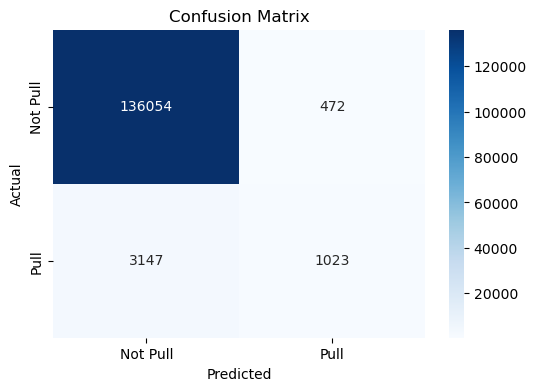

ROC-AUC Score: 0.9755


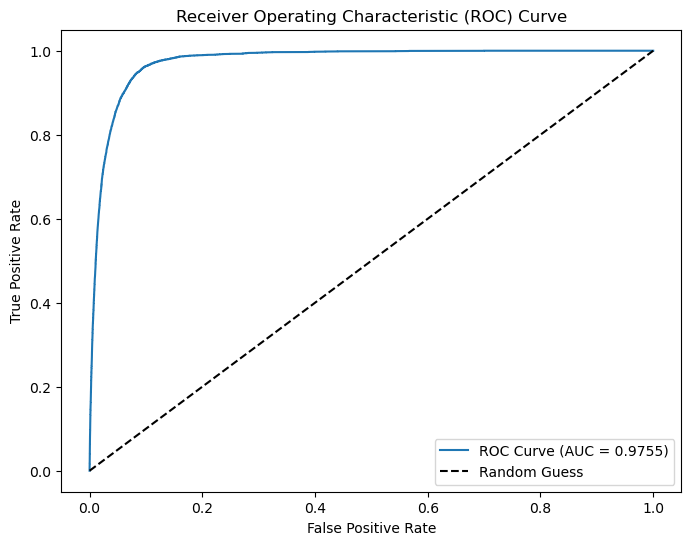

<Figure size 1200x800 with 0 Axes>

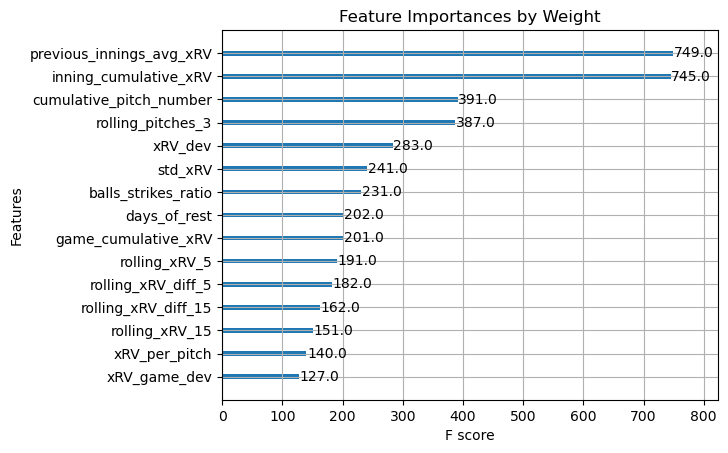

<Figure size 1200x800 with 0 Axes>

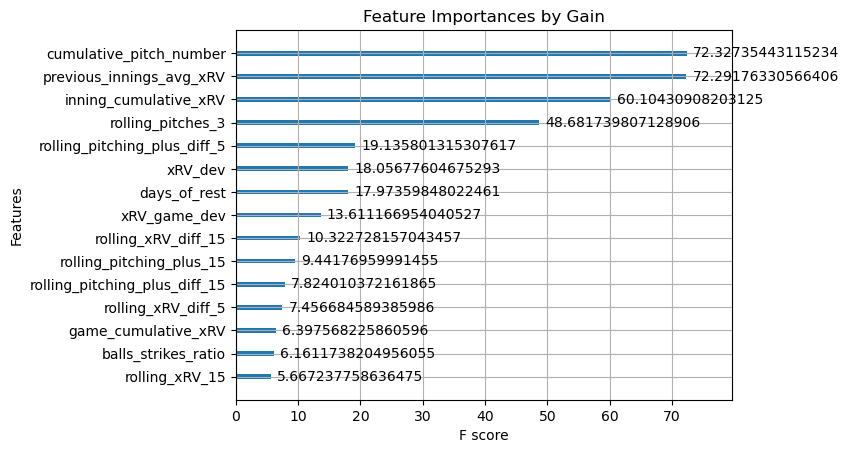

<Figure size 1200x800 with 0 Axes>

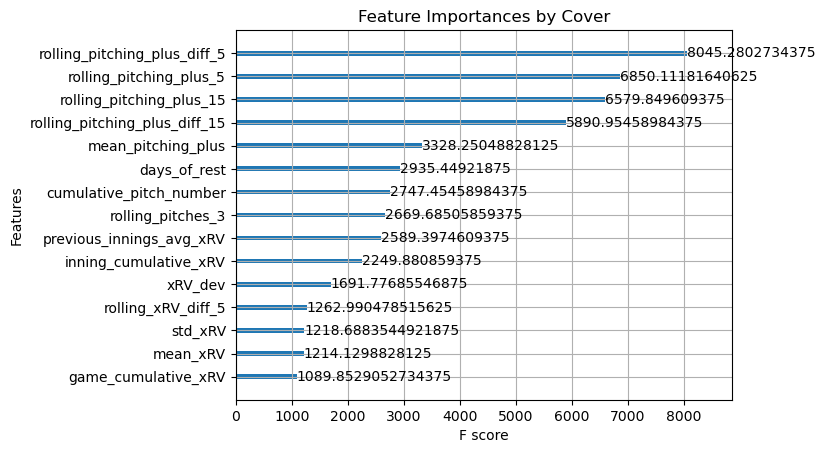

In [7]:
# RUN FOR EVERY PITCHER

# Define the target variable
target = 'is_last_pitch'

# Check if target exists
if target not in total_df.columns:
    raise ValueError(f"The target variable '{target}' is missing from the DataFrame.")

# Separate features and target
X = total_df[feature_columns]
y = total_df[target]

# Verify feature and target shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for missing values in features
missing_values = X.isnull().sum()
print("Missing Values in Each Feature:")
print(missing_values[missing_values > 0])


# If there are missing values, fill them with the median of each feature
if missing_values.sum() > 0:
    X.fillna(X.median(), inplace=True)
    print("Missing values have been filled with median values.")
else:
    print("No missing values detected.")

# Verify that there are no missing values left
print("Total Missing Values After Imputation:", X.isnull().sum().sum())  # Should be 0

# Calculate class distribution
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets (80-20 split)
# Using stratify=y to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Verify the split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)
print("\nTraining Set Target Distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting Set Target Distribution:")
print(y_test.value_counts(normalize=True))

# Initialize the XGBoost Classifier without class balancing
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=10, 
    random_state=42
)

# Train the model
xgb_clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=True
)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Pull', 'Pull'], yticklabels=['Not Pull', 'Pull'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Feature Importances by Weight
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='weight')
plt.title('Feature Importances by Weight')
plt.show()

# Plot Feature Importances by Gain
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='gain')
plt.title('Feature Importances by Gain')
plt.show()

# Plot Feature Importances by Cover
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='cover')
plt.title('Feature Importances by Cover')
plt.show()


In [8]:
# unusually high accuracy, debug:
# Check shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Ensure no overlap between training and testing indices
assert set(X_train.index).isdisjoint(set(X_test.index)), "Overlap detected between training and testing sets!"


X_train shape: (562784, 22)
X_test shape: (140696, 22)


In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the XGBoost Classifier without early stopping
xgb_clf_cv = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Evaluate model using cross-validation
scores = cross_val_score(
    xgb_clf_cv, X, y, cv=skf, scoring='accuracy', n_jobs=-1
)
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Cross-Validation Accuracy Scores: [0.97429209 0.97400779 0.97454085 0.97414994 0.97432763]
Mean Accuracy: 0.9742636606584408


In [10]:
# Combine features and target into a single DataFrame
data_with_target = X.copy()
data_with_target[target] = y

# Calculate the correlation matrix
corr_matrix = data_with_target.corr()

# Extract correlations with the target variable
target_corr = corr_matrix[target].drop(target)  # Exclude self-correlation

# Print the correlations sorted by absolute value
print("Correlation of features with the target variable:")
print(target_corr.abs().sort_values(ascending=False))


Correlation of features with the target variable:
rolling_pitches_3                0.118959
xRV_dev                          0.047512
rolling_xRV_diff_15              0.045621
rolling_pitching_plus_diff_15    0.045621
rolling_pitching_plus_diff_5     0.044395
rolling_xRV_diff_5               0.044395
xRV_game_dev                     0.044390
std_xRV                          0.038803
std_pitching_plus                0.038803
days_of_rest                     0.024637
cumulative_pitch_number          0.019079
xRV_per_pitch                    0.014575
previous_innings_avg_xRV         0.009913
inning_cumulative_xRV            0.008957
mean_xRV                         0.006028
mean_pitching_plus               0.006028
game_cumulative_xRV              0.002787
rolling_pitching_plus_15         0.001062
rolling_xRV_15                   0.001062
balls_strikes_ratio              0.001017
rolling_pitching_plus_5          0.000745
rolling_xRV_5                    0.000745
Name: is_last_pitch, dtype

In [11]:
# Get feature importances from the model
importances = xgb_clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("\nFeature Importances from the Model:")
print(feature_importance_df)



Feature Importances from the Model:
                          Feature  Importance
16        cumulative_pitch_number    0.176512
21       previous_innings_avg_xRV    0.176425
18          inning_cumulative_xRV    0.146682
6               rolling_pitches_3    0.118806
13   rolling_pitching_plus_diff_5    0.046700
4                         xRV_dev    0.044067
15                   days_of_rest    0.043864
5                    xRV_game_dev    0.033218
12            rolling_xRV_diff_15    0.025192
10       rolling_pitching_plus_15    0.023042
14  rolling_pitching_plus_diff_15    0.019094
11             rolling_xRV_diff_5    0.018198
19            game_cumulative_xRV    0.015613
17            balls_strikes_ratio    0.015036
8                  rolling_xRV_15    0.013831
2              mean_pitching_plus    0.013512
9         rolling_pitching_plus_5    0.013111
0                        mean_xRV    0.013064
20                  xRV_per_pitch    0.012853
7                   rolling_xRV_5    0.0126

In [12]:
# NOTE: performs worse than prior model
#     accuracy                           0.97    140696
#    macro avg       0.74      0.98      0.81    140696
# weighted avg       0.98      0.97      0.97    140696

# from sklearn.model_selection import RandomizedSearchCV

# # Calculate scale_pos_weight
# scale_pos_weight = class_counts[0] / class_counts[1]

# # Define the parameter distributions for Randomized Search
# param_distributions = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5],
#     'learning_rate': [0.01, 0.05],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'gamma': [0],
# }

# # Initialize the XGBoost Classifier with scale_pos_weight
# xgb_clf_tuned = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='auc',  # Use AUC for imbalanced data
#     use_label_encoder=False,
#     random_state=42,
#     scale_pos_weight=scale_pos_weight,
# )

# # Initialize Randomized Search with Stratified K-Fold
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# random_search = RandomizedSearchCV(
#     estimator=xgb_clf_tuned,
#     param_distributions=param_distributions,
#     n_iter=5,  # Limit to 5 iterations
#     scoring='roc_auc',
#     cv=cv,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,
# )

# # Perform Randomized Search
# random_search.fit(X_train, y_train)

# # Best Parameters
# print("Best Parameters from Randomized Search:")
# print(random_search.best_params_)

# # Best Score
# print(f"Best ROC-AUC Score from Randomized Search: {random_search.best_score_:.4f}")

# # Retrieve the best parameters
# best_params = random_search.best_params_

# # Initialize the XGBoost Classifier with best parameters
# xgb_clf_best = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='auc',
#     use_label_encoder=False,
#     random_state=42,
#     scale_pos_weight=scale_pos_weight,
#     early_stopping_rounds=10,
#     **best_params,
# )

# # Train the model
# xgb_clf_best.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_test, y_test)],
#     verbose=True,
# )

# # Make predictions on the test set
# y_pred_best = xgb_clf_best.predict(X_test)
# y_pred_proba_best = xgb_clf_best.predict_proba(X_test)[:, 1]

# # Classification Report
# print("Classification Report (Tuned Model):")
# print(classification_report(y_test, y_pred_best))

# # Confusion Matrix
# cm_best = confusion_matrix(y_test, y_pred_best)
# plt.figure(figsize=(6, 4))
# sns.heatmap(
#     cm_best,
#     annot=True,
#     fmt='d',
#     cmap='Greens',
#     xticklabels=['Not Pull', 'Pull'],
#     yticklabels=['Not Pull', 'Pull'],
# )
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix (Tuned Model)')
# plt.show()

# # ROC-AUC Score
# roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
# print(f"ROC-AUC Score (Tuned Model): {roc_auc_best:.4f}")

# # Plot ROC Curve
# fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_best, tpr_best, label=f'ROC Curve (AUC = {roc_auc_best:.4f})')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Tuned Model')
# plt.legend()
# plt.show()


In [13]:
starters_df = total_df[total_df['role'] == 'starter'].copy()
relievers_df = total_df[total_df['role'] == 'reliever'].copy()

Features shape: (405644, 22)
Target shape: (405644,)
Missing Values in Each Feature:
mean_xRV                          4969
mean_pitching_plus                4969
xRV_dev                            248
xRV_game_dev                      4969
rolling_pitches_3                59334
rolling_xRV_5                     4969
rolling_xRV_15                    4969
rolling_pitching_plus_5           4969
rolling_pitching_plus_15          4969
rolling_xRV_diff_5                4969
rolling_xRV_diff_15               4969
rolling_pitching_plus_diff_5      4969
rolling_pitching_plus_diff_15     4969
previous_innings_avg_xRV             1
dtype: int64
Missing values have been filled with median values.
Total Missing Values After Imputation: 0
Class Distribution:
is_last_pitch
False    400675
True       4969
Name: count, dtype: int64
Training Set Shape: (324515, 22)
Testing Set Shape: (81129, 22)

Training Set Target Distribution:
is_last_pitch
False    0.987751
True     0.012249
Name: proportion, dtyp

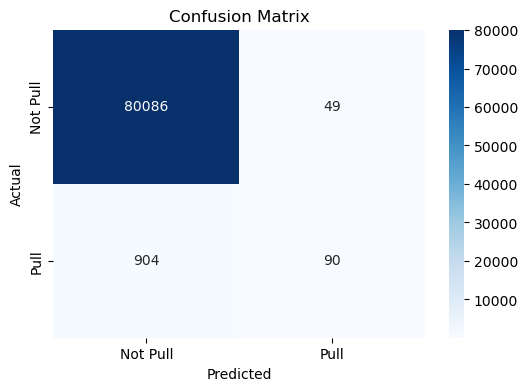

ROC-AUC Score: 0.9711


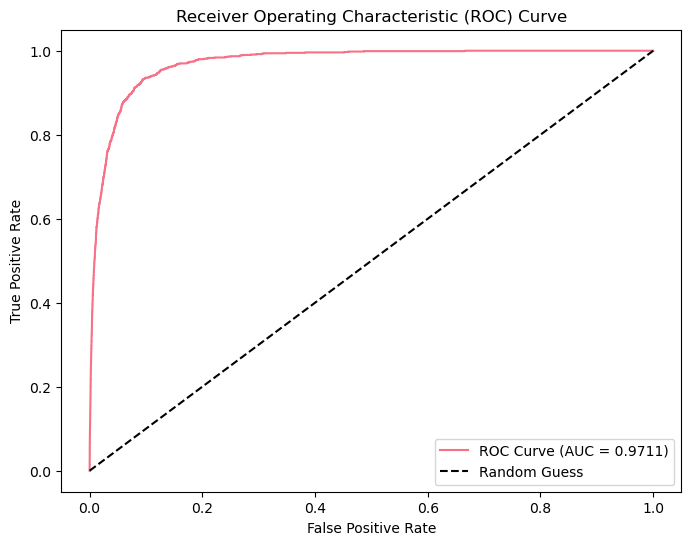

<Figure size 1200x800 with 0 Axes>

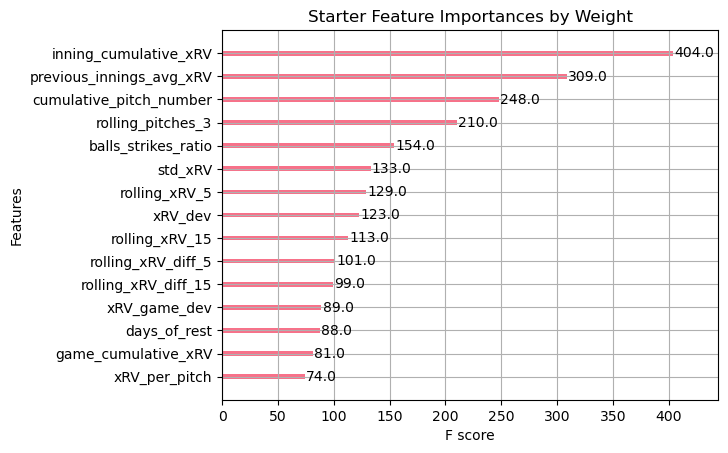

<Figure size 1200x800 with 0 Axes>

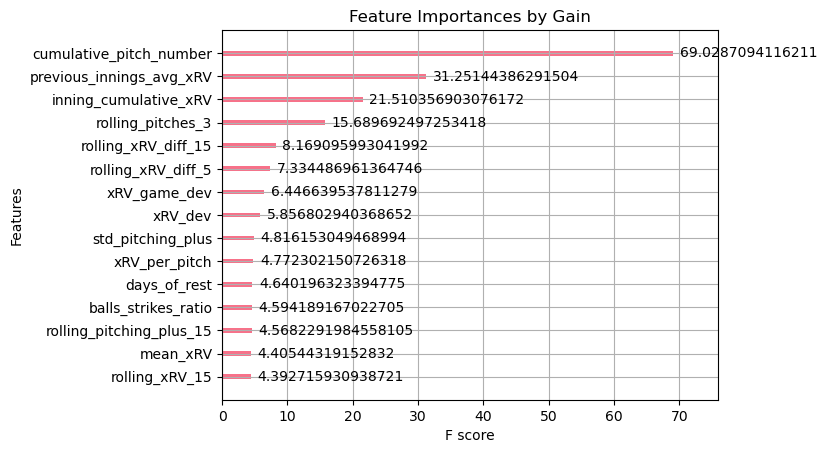

<Figure size 1200x800 with 0 Axes>

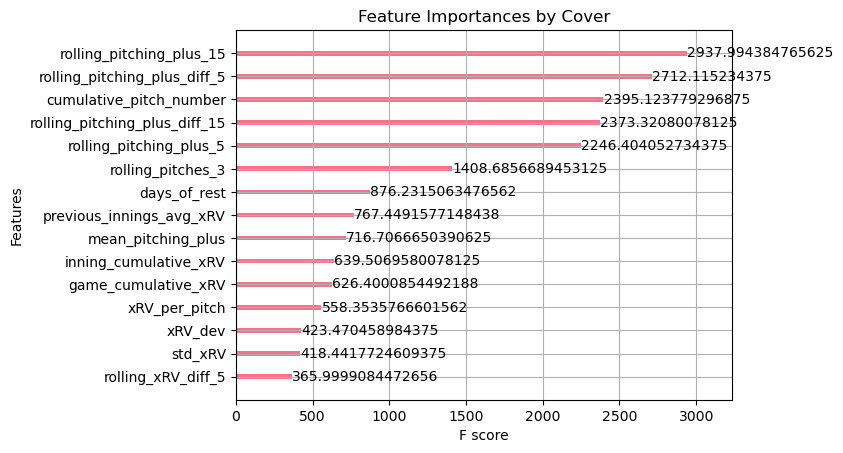

Feature Importances by Weight:
inning_cumulative_xRV: 404.0
previous_innings_avg_xRV: 309.0
cumulative_pitch_number: 248.0
rolling_pitches_3: 210.0
balls_strikes_ratio: 154.0
std_xRV: 133.0
rolling_xRV_5: 129.0
xRV_dev: 123.0
rolling_xRV_15: 113.0
rolling_xRV_diff_5: 101.0
rolling_xRV_diff_15: 99.0
xRV_game_dev: 89.0
days_of_rest: 88.0
game_cumulative_xRV: 81.0
xRV_per_pitch: 74.0
mean_xRV: 68.0
rolling_pitching_plus_15: 10.0
mean_pitching_plus: 8.0
rolling_pitching_plus_diff_15: 6.0
rolling_pitching_plus_5: 5.0
std_pitching_plus: 1.0
rolling_pitching_plus_diff_5: 1.0


In [19]:
# RUN FOR STARTERS

# Use starters_df for further processing
# Define feature columns


# Define the target variable
target = 'is_last_pitch'

# Check if target exists
if target not in starters_df.columns:
    raise ValueError(f"The target variable '{target}' is missing from the DataFrame.")

# Separate features and target
X = starters_df[feature_columns]
y = starters_df[target]


# Verify feature and target shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for missing values in features
missing_values = X.isnull().sum()
print("Missing Values in Each Feature:")
print(missing_values[missing_values > 0])


# If there are missing values, fill them with the median of each feature
if missing_values.sum() > 0:
    X.fillna(X.median(), inplace=True)
    print("Missing values have been filled with median values.")
else:
    print("No missing values detected.")

# Verify that there are no missing values left
print("Total Missing Values After Imputation:", X.isnull().sum().sum())  # Should be 0

# Calculate class distribution
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets (80-20 split)
# Using stratify=y to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Verify the split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)
print("\nTraining Set Target Distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting Set Target Distribution:")
print(y_test.value_counts(normalize=True))

# Initialize the XGBoost Classifier without class balancing
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=10, 
    random_state=42
)

# Train the model
xgb_clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=True
)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Pull', 'Pull'], yticklabels=['Not Pull', 'Pull'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Feature Importances by Weight
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='weight')
plt.title('Starter Feature Importances by Weight')
plt.show()

# Plot Feature Importances by Gain
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='gain')
plt.title('Feature Importances by Gain')
plt.show()

# Plot Feature Importances by Cover
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='cover')
plt.title('Feature Importances by Cover')
plt.show()
# Extract feature importances by weight
feature_importances = xgb_clf.get_booster().get_score(importance_type='weight')

# Sort feature importances by their weight
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Display feature importances
print("Feature Importances by Weight:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Features shape: (297836, 22)
Target shape: (297836,)
Missing Values in Each Feature:
mean_xRV                         15881
mean_pitching_plus               15881
xRV_dev                            545
xRV_game_dev                     15881
rolling_pitches_3                34982
rolling_xRV_5                    15881
rolling_xRV_15                   15881
rolling_pitching_plus_5          15881
rolling_pitching_plus_15         15881
rolling_xRV_diff_5               15881
rolling_xRV_diff_15              15881
rolling_pitching_plus_diff_5     15881
rolling_pitching_plus_diff_15    15881
dtype: int64
Missing values have been filled with median values.
Total Missing Values After Imputation: 0
Class Distribution:
is_last_pitch
False    281955
True      15881
Name: count, dtype: int64
Training Set Shape: (238268, 22)
Testing Set Shape: (59568, 22)

Training Set Target Distribution:
is_last_pitch
False    0.946678
True     0.053322
Name: proportion, dtype: float64

Testing Set Target Distribu

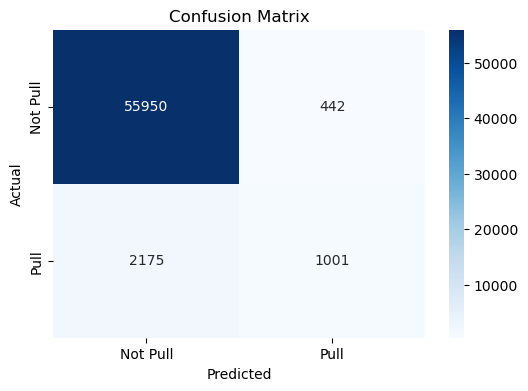

ROC-AUC Score: 0.9700


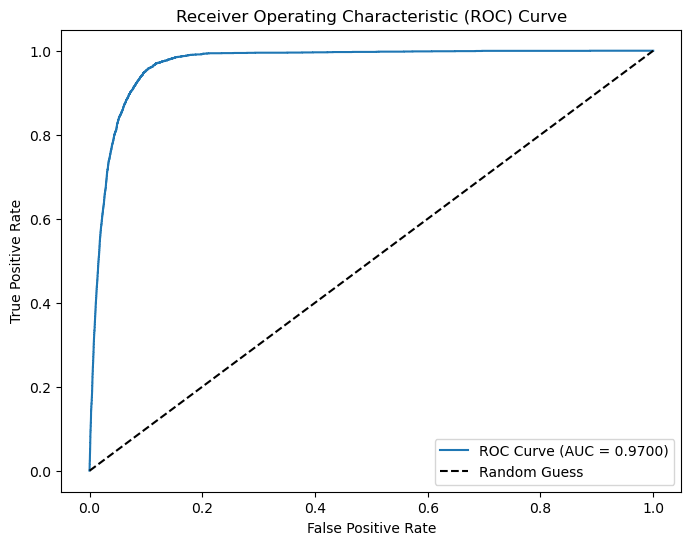

<Figure size 1200x800 with 0 Axes>

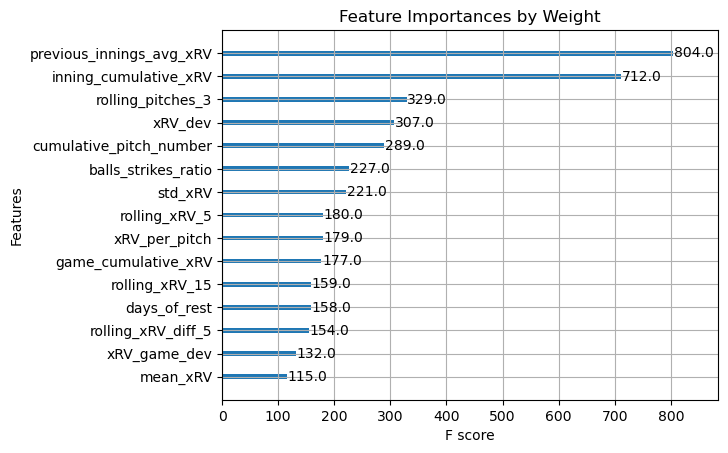

<Figure size 1200x800 with 0 Axes>

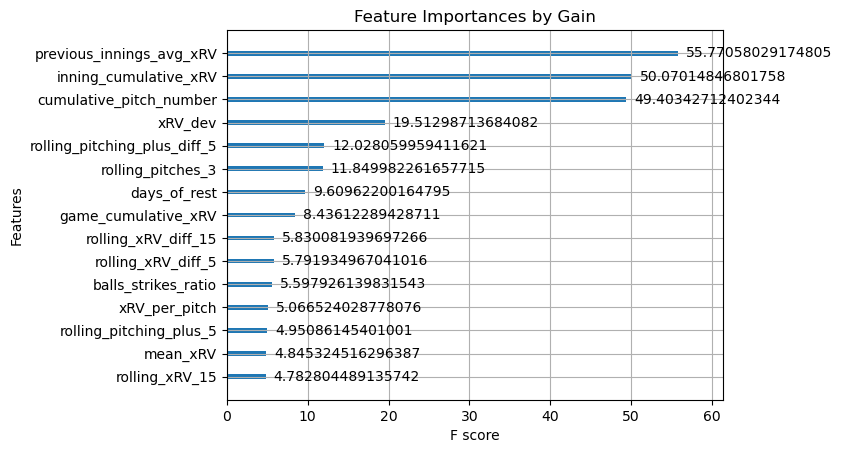

<Figure size 1200x800 with 0 Axes>

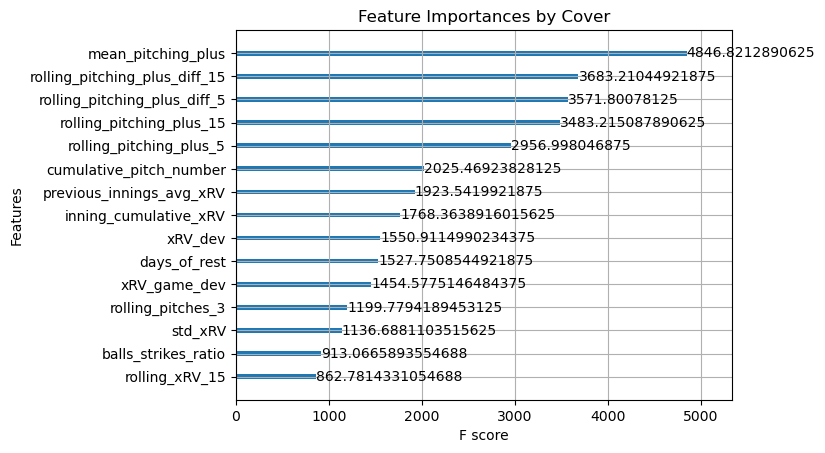

In [ ]:
# RUN FOR RELIEVERS

# Use relievers_df for further processing

# Define the target variable
target = 'is_last_pitch'

# Check if target exists
if target not in relievers_df.columns:
    raise ValueError(f"The target variable '{target}' is missing from the DataFrame.")

# Separate features and target
X = relievers_df[feature_columns]
y = relievers_df[target]

# Verify feature and target shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for missing values in features
missing_values = X.isnull().sum()
print("Missing Values in Each Feature:")
print(missing_values[missing_values > 0])


# If there are missing values, fill them with the median of each feature
if missing_values.sum() > 0:
    X.fillna(X.median(), inplace=True)
    print("Missing values have been filled with median values.")
else:
    print("No missing values detected.")

# Verify that there are no missing values left
print("Total Missing Values After Imputation:", X.isnull().sum().sum())  # Should be 0

# Calculate class distribution
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets (80-20 split)
# Using stratify=y to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Verify the split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)
print("\nTraining Set Target Distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting Set Target Distribution:")
print(y_test.value_counts(normalize=True))

# Initialize the XGBoost Classifier without class balancing
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=10, 
    random_state=42
)

# Train the model
xgb_clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=True
)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Pull', 'Pull'], yticklabels=['Not Pull', 'Pull'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Feature Importances by Weight
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='weight')
plt.title('Feature Importances by Weight')
plt.show()

# Plot Feature Importances by Gain
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='gain')
plt.title('Feature Importances by Gain')
plt.show()

# Plot Feature Importances by Cover
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='cover')
plt.title('Feature Importances by Cover')
plt.show()



Starting the model training pipeline...
Starting model building process...
Class balance ratio (negative/positive): 80.64

Performing RandomizedSearchCV with 25 iterations...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


Model training completed!
Best parameters found: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'max_delta_step': 3, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.8}

Model Performance Metrics:
accuracy: 0.8872
roc_auc: 0.9639
precision: 0.0913
recall: 0.9165
f1: 0.1660


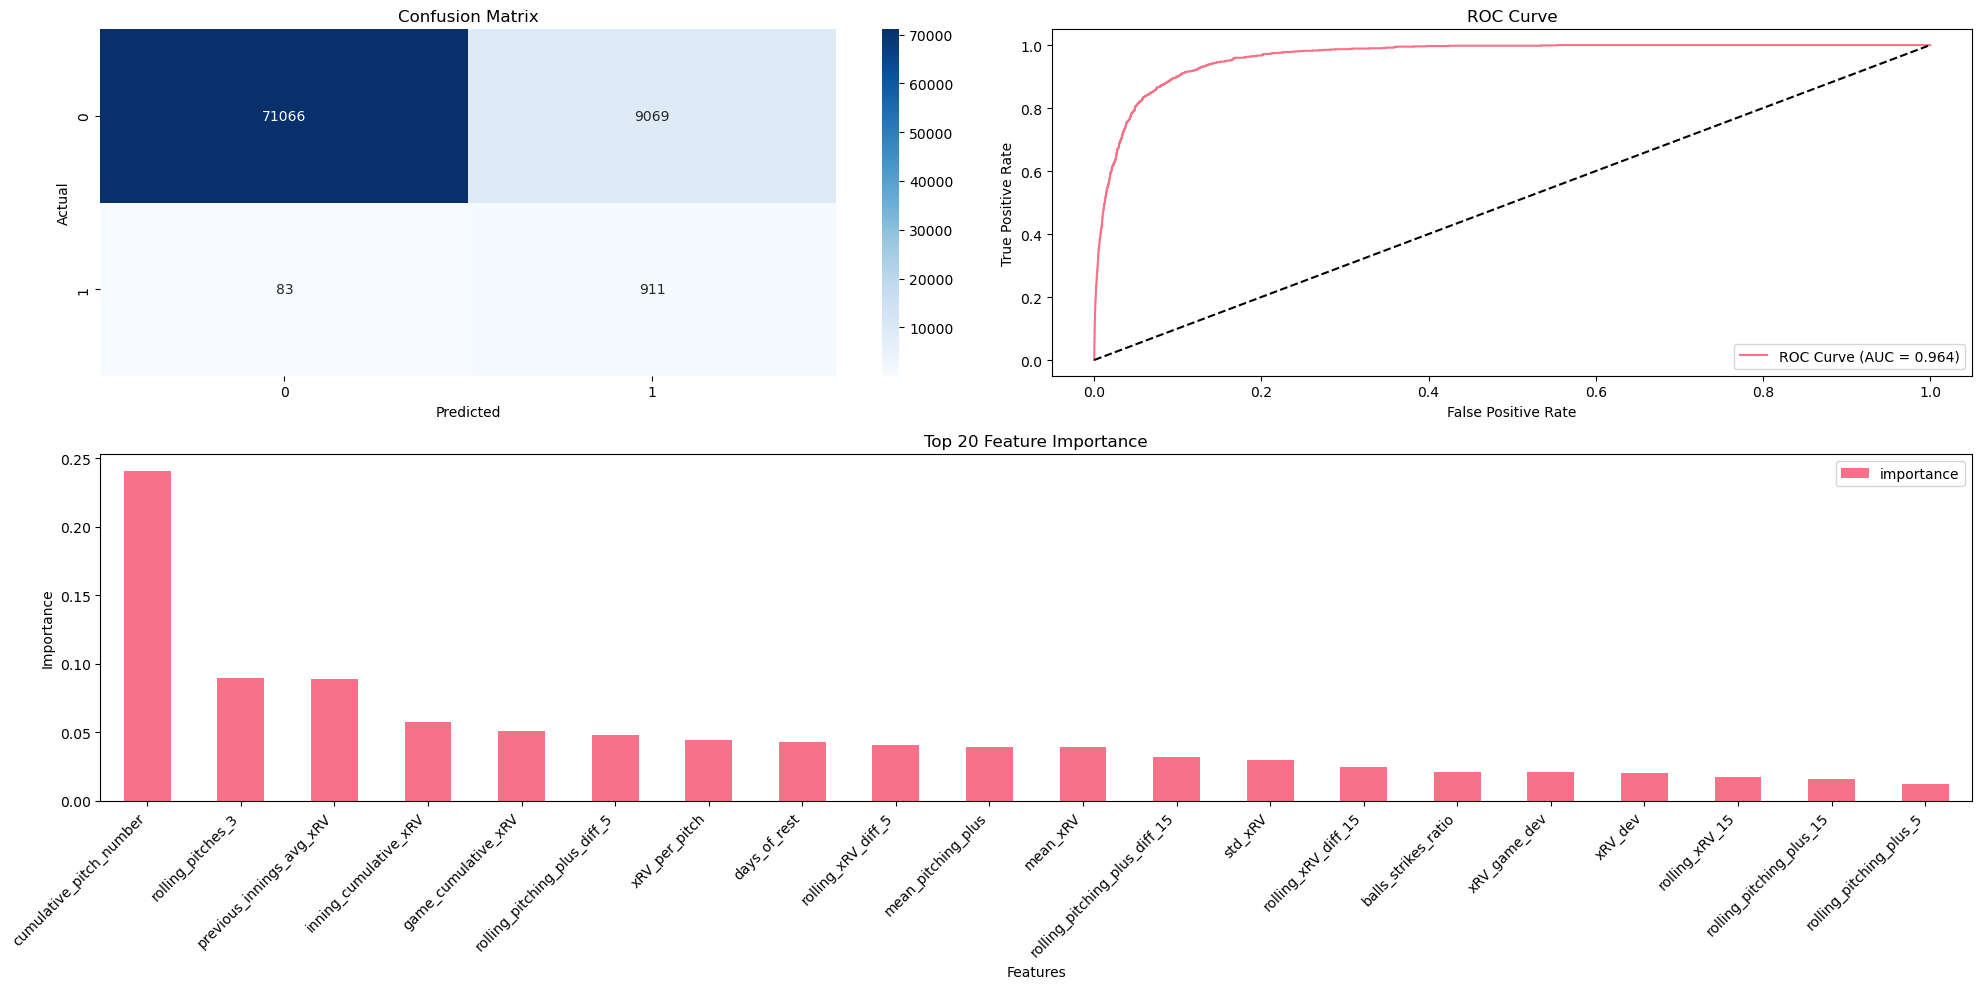

Confusion Matrix:
                 Predicted Not Pull  Predicted Pull
Actual Not Pull               71066            9069
Actual Pull                      83             911


In [16]:
# Ran on Starters, class balancing and parameter editing model. 900 games correct

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data processing and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Machine learning
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_palette("husl")

X = starters_df[feature_columns]
y = starters_df[target]

# Split the data into training and testing sets (80-20 split)
# Using stratify=y to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

def build_xgboost_classifier(X_train, X_test, y_train, y_test):
    """
    Build and train an XGBoost classifier with proper tuning and evaluation
    """
    print("Starting model building process...")
    
    # Calculate class weights
    negative_class = (y_train == 0).sum()
    positive_class = (y_train == 1).sum()
    scale_pos_weight = negative_class / positive_class
    print(f"Class balance ratio (negative/positive): {scale_pos_weight:.2f}")
    
    # Define base model without early_stopping_rounds
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric=['auc', 'aucpr'],  # Add precision-recall AUC
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        max_delta_step=1,  # Help with class imbalance
        min_child_weight=5  # Increase to prevent overfitting on rare class
    )

    # Adjust param_grid to focus on class imbalance:
    param_grid = {
        'max_depth': [2, 3, 4],  # Reduced depth to prevent overfitting
        'min_child_weight': [3, 5, 7],
        'learning_rate': [0.01, 0.03, 0.05],  # Smaller learning rates
        'n_estimators': [200, 300, 400],  # More trees
        'gamma': [0.1, 0.2, 0.3],  # Increased gamma for better split quality
        'subsample': [0.6, 0.7, 0.8],  # More aggressive subsampling
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_delta_step': [1, 2, 3]  # Help with class imbalance
    }
    
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate total iterations for progress bar
    n_iter = 25
    print(f"\nPerforming RandomizedSearchCV with {n_iter} iterations...")
    
    # In RandomizedSearchCV, change scoring
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=25,
        scoring='average_precision',  # Change to precision-focused metric
        cv=cv,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model without eval_set
    search.fit(X_train, y_train)
    
    print("\nModel training completed!")
    print(f"Best parameters found: {search.best_params_}")
    
    # Get best parameters
    best_params = search.best_params_
    
    # Initialize best model with best parameters
    best_model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        early_stopping_rounds=20,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    # Retrain the model with early stopping
    best_model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return best_model, metrics, feature_importance, y_pred, y_pred_proba

def plot_model_evaluation(y_test, y_pred, y_pred_proba, feature_importance):
    """
    Create evaluation plots for the model
    """
    # Set up the figure layout
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    
    # 3. Feature Importance
    ax3 = fig.add_subplot(gs[1, :])
    feature_importance.head(20).plot(kind='bar', x='feature', y='importance', ax=ax3)
    ax3.set_title('Top 20 Feature Importance')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Run the pipeline
print("Starting the model training pipeline...")
model, metrics, feature_importance, y_pred, y_pred_proba = build_xgboost_classifier(
    X_train, X_test, y_train, y_test
)

# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot evaluation
plot_model_evaluation(y_test, y_pred, y_pred_proba, feature_importance)

def print_confusion_matrix(y_true, y_pred, class_names):
    """
    Prints the confusion matrix with class labels.
    
    Parameters:
    - y_true: Array-like of true labels
    - y_pred: Array-like of predicted labels
    - class_names: List of class names in the order [negative_class, positive_class]
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=[f'Actual {name}' for name in class_names], columns=[f'Predicted {name}' for name in class_names])
    print("Confusion Matrix:")
    print(cm_df)


class_names = ['Not Pull', 'Pull']
print_confusion_matrix(y_test, y_pred, class_names)

Starting the model training pipeline...
Starting model building process...
Class balance ratio (negative/positive): 17.75

Performing RandomizedSearchCV with 25 iterations...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:18:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


Model training completed!
Best parameters found: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'max_delta_step': 3, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.8}

Model Performance Metrics:
accuracy: 0.6431
roc_auc: 0.7931
precision: 0.1128
recall: 0.8290
f1: 0.1985


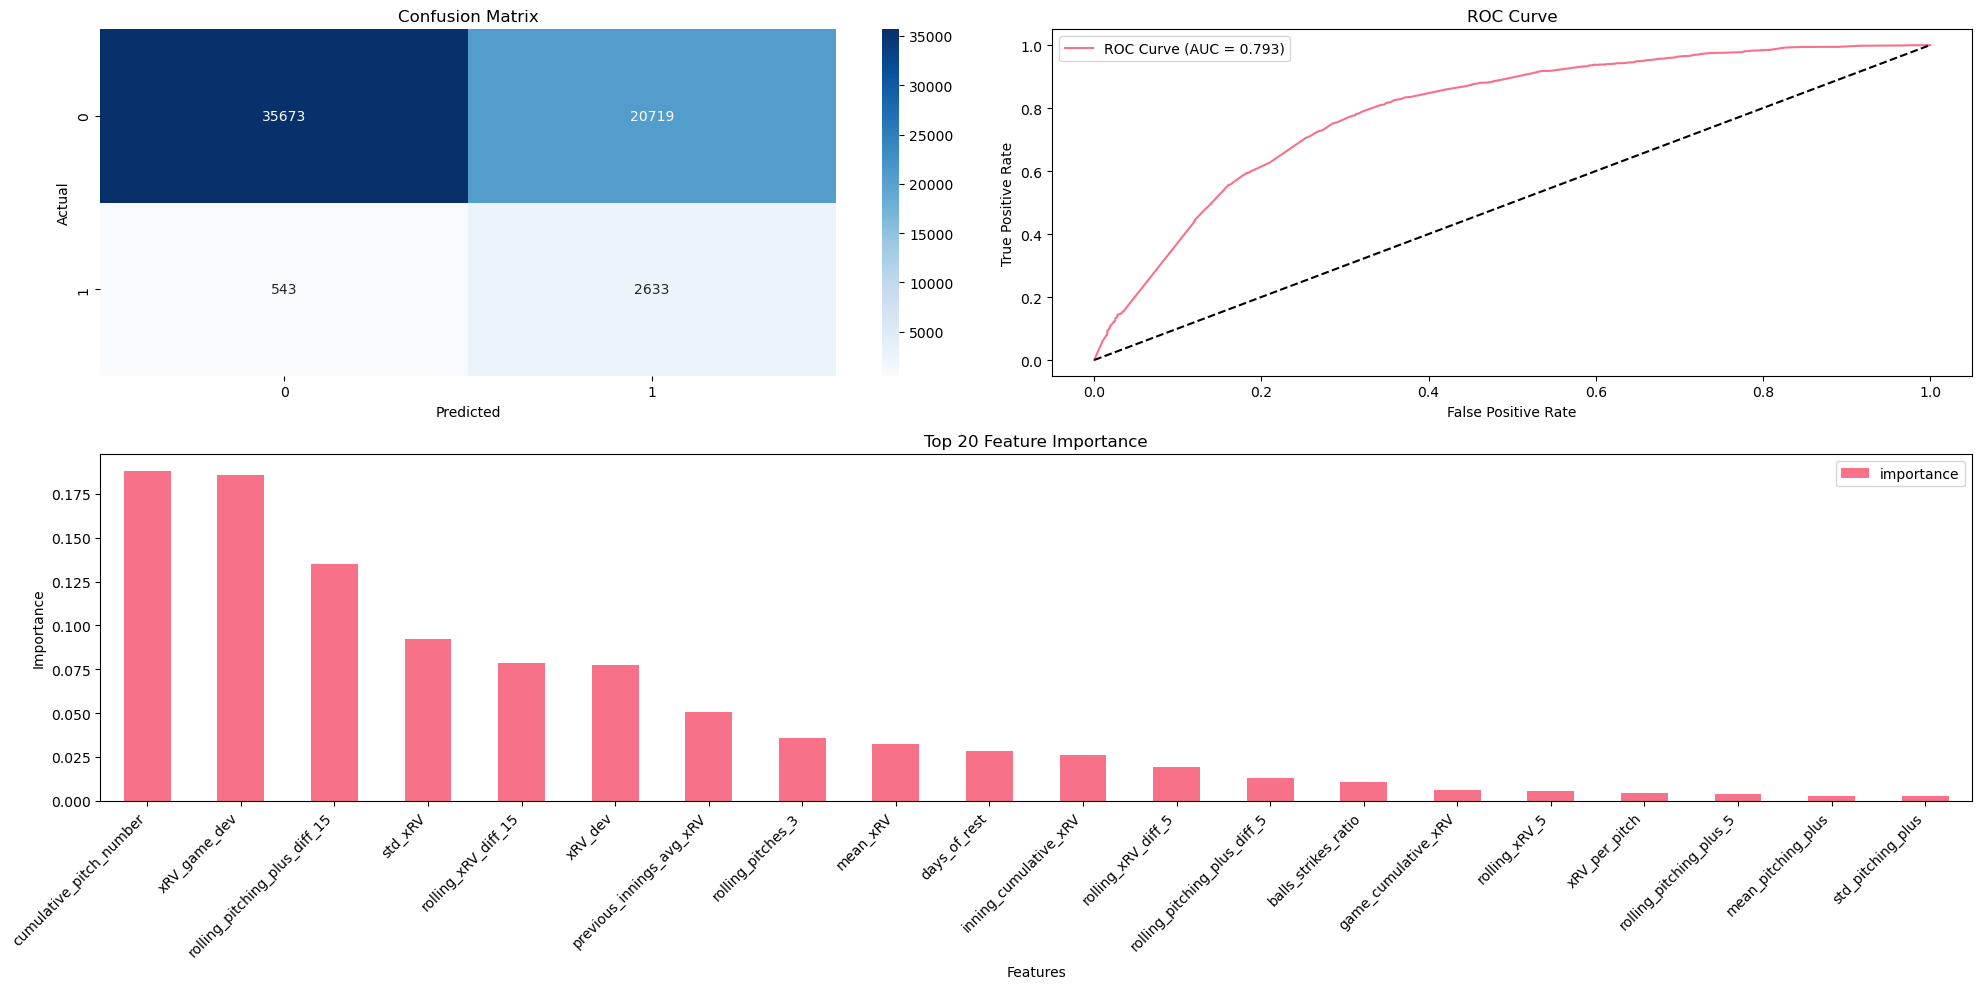

Confusion Matrix:
                 Predicted Not Pull  Predicted Pull
Actual Not Pull               35673           20719
Actual Pull                     543            2633


In [17]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data processing and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Machine learning
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_palette("husl")

X = relievers_df[feature_columns]
y = relievers_df[target]

# Split the data into training and testing sets (80-20 split)
# Using stratify=y to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

def build_xgboost_classifier(X_train, X_test, y_train, y_test):
    """
    Build and train an XGBoost classifier with proper tuning and evaluation
    """
    print("Starting model building process...")
    
    # Calculate class weights
    negative_class = (y_train == 0).sum()
    positive_class = (y_train == 1).sum()
    scale_pos_weight = negative_class / positive_class
    print(f"Class balance ratio (negative/positive): {scale_pos_weight:.2f}")
    
    # Define base model without early_stopping_rounds
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric=['auc', 'aucpr'],  # Add precision-recall AUC
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        max_delta_step=1,  # Help with class imbalance
        min_child_weight=5  # Increase to prevent overfitting on rare class
    )

    # Adjust param_grid to focus on class imbalance:
    param_grid = {
        'max_depth': [2, 3, 4],  # Reduced depth to prevent overfitting
        'min_child_weight': [3, 5, 7],
        'learning_rate': [0.01, 0.03, 0.05],  # Smaller learning rates
        'n_estimators': [200, 300, 400],  # More trees
        'gamma': [0.1, 0.2, 0.3],  # Increased gamma for better split quality
        'subsample': [0.6, 0.7, 0.8],  # More aggressive subsampling
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_delta_step': [1, 2, 3]  # Help with class imbalance
    }
    
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate total iterations for progress bar
    n_iter = 25
    print(f"\nPerforming RandomizedSearchCV with {n_iter} iterations...")
    
    # In RandomizedSearchCV, change scoring
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=25,
        scoring='average_precision',  # Change to precision-focused metric
        cv=cv,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model without eval_set
    search.fit(X_train, y_train)
    
    print("\nModel training completed!")
    print(f"Best parameters found: {search.best_params_}")
    
    # Get best parameters
    best_params = search.best_params_
    
    # Initialize best model with best parameters
    best_model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        early_stopping_rounds=20,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    # Retrain the model with early stopping
    best_model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return best_model, metrics, feature_importance, y_pred, y_pred_proba

def plot_model_evaluation(y_test, y_pred, y_pred_proba, feature_importance):
    """
    Create evaluation plots for the model
    """
    # Set up the figure layout
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    
    # 3. Feature Importance
    ax3 = fig.add_subplot(gs[1, :])
    feature_importance.head(20).plot(kind='bar', x='feature', y='importance', ax=ax3)
    ax3.set_title('Top 20 Feature Importance')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Run the pipeline
print("Starting the model training pipeline...")
model, metrics, feature_importance, y_pred, y_pred_proba = build_xgboost_classifier(
    X_train, X_test, y_train, y_test
)

# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot evaluation
plot_model_evaluation(y_test, y_pred, y_pred_proba, feature_importance)

def print_confusion_matrix(y_true, y_pred, class_names):
    """
    Prints the confusion matrix with class labels.
    
    Parameters:
    - y_true: Array-like of true labels
    - y_pred: Array-like of predicted labels
    - class_names: List of class names in the order [negative_class, positive_class]
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=[f'Actual {name}' for name in class_names], columns=[f'Predicted {name}' for name in class_names])
    print("Confusion Matrix:")
    print(cm_df)


class_names = ['Not Pull', 'Pull']
print_confusion_matrix(y_test, y_pred, class_names)